 # III. Run Predictive Model

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import gc
import time
import pickle
import xgboost as xgb
%matplotlib inline
pd.set_option('display.max_columns', 500)

In [2]:
statFeat = pd.read_csv('statFeatures.csv', index_col = 0)
statResult = pd.read_csv('statResults.csv', index_col = 0)

stat = pd.merge(statFeat, statResult, on = ['PA', 'batter'])

In [3]:
date = '06172018'
outcomes = ['outcome1B', 'outcome2B', 'outcome3B', 'outcomeHR']
outcome = 'outcomeHR'
outcomes.remove(outcome)
output = 'HR'

In [4]:
pitchers = stat[['game_date','pitcher', 'p_throws', 'pitcherHR', \
                'pitcherK', 'pitcherGB', 'pitcherFB', 'pitcherLD']].sort_values('game_date', ascending = False)

pitchers.drop_duplicates('pitcher', keep = 'first', inplace = True)

In [5]:
#create holdout; remove small sample hitters
holdout = stat.sort_values('PA', ascending = False).drop_duplicates('batter', keep = 'first')
smallSample = holdout[holdout['PA'] <= 50]
holdout.drop(smallSample.index, axis = 0, inplace = True)

#remove holdout and small sample from train
train = stat.drop(holdout.index, axis=0)
train = train[~train['batter'].isin(smallSample['batter'])]
valid = holdout[[outcome, 'batter', 'pitcher']]
#players = train['batter']
train.drop(['batter', 'pitcher'], inplace = True, axis = 1)

In [6]:
holdout.drop(['game_date', 'pitcher', 'p_throws', \
             'pitcherHR', 'pitcherK', 'pitcherGB', 'pitcherFB', \
              'pitcherLD'], inplace = True, axis = 1)

train.drop(['game_date', 'p_throws', 'b_stands'], inplace = True, axis = 1)

holdout.drop(outcomes, axis = 1, inplace = True)
train.drop(outcomes, axis = 1, inplace = True)

In [7]:
pitchers['pitcher'] =  pitchers['pitcher'].astype(int)
pitchers.drop('game_date', inplace = True, axis = 1)
startersBat = pd.read_csv('startersBat.csv', index_col  = 0)
pitchers = pd.merge(pitchers, startersBat, on = 'pitcher', how = 'left')
holdout = pd.merge(holdout, pitchers, on = 'batter', how = 'left')
holdout['platoon'] = np.where(holdout['b_stands'] == holdout['p_throws'], 1, 0)
holdout.drop(['p_throws', 'b_stands'], inplace = True, axis = 1)
holdout = holdout[train.columns]

In [8]:
#split features and predictors - time series
x1 = train[0:int(round((.75*train.shape[0])))]
y1 = x1[outcome]
x1.drop([outcome], inplace = True, axis = 1)

x2 = train[(int(round((.75*train.shape[0]))) + 1):(train.shape[0] + 1)]
y2 = x2[outcome]
x2.drop([outcome], inplace = True, axis = 1)

C:\Users\z829348\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\z829348\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [9]:
trainSplit = xgb.DMatrix(x1, y1)
testSplit = xgb.DMatrix(x2, y2)

params = {'eta': 0.1, 
          'max_depth': 2, 
          'subsample': 0.9, 
          'colsample_bytree': 0.7, 
          'colsample_bylevel':0.7,
          'min_child_weight':1,
          'alpha':4,
          'objective': 'binary:logistic', 
          'eval_metric': 'auc', 
          'random_state': 99, 
          'silent': True}

start_time = time.time()

print('[{}] Start XGBoost Training'.format(time.time() - start_time))

#del train
gc.collect()

watchlist = [(trainSplit, 'train'), (testSplit, 'valid')]
model = xgb.train(params, trainSplit, 1000, watchlist, maximize=True, verbose_eval=10, early_stopping_rounds = 100)

print('[{}] Finish XGBoost Training'.format(time.time() - start_time))

[0.000997304916381836] Start XGBoost Training
[0]	train-auc:0.63492	valid-auc:0.620106
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[10]	train-auc:0.669172	valid-auc:0.633528
[20]	train-auc:0.679916	valid-auc:0.587607
[30]	train-auc:0.684296	valid-auc:0.61362
[40]	train-auc:0.692555	valid-auc:0.626804
[50]	train-auc:0.693502	valid-auc:0.634721
[60]	train-auc:0.702376	valid-auc:0.639343
[70]	train-auc:0.706389	valid-auc:0.636617
[80]	train-auc:0.710137	valid-auc:0.640485
[90]	train-auc:0.714098	valid-auc:0.64155
[100]	train-auc:0.719646	valid-auc:0.632709
[110]	train-auc:0.723993	valid-auc:0.633966
[120]	train-auc:0.726145	valid-auc:0.632599
[130]	train-auc:0.729246	valid-auc:0.631895
[140]	train-auc:0.732202	valid-auc:0.633235
[150]	train-auc:0.735235	valid-auc:0.632974
[160]	train-auc:0.738373	valid-auc:0.632261
[170]	train-auc:0.740878	valid-auc:0.630645
[180]	train-auc:0.744487	valid-a

In [10]:
holdout.drop(outcome, inplace = True, axis = 1)
preds = model.predict(xgb.DMatrix(holdout), ntree_limit=model.best_ntree_limit)

print('[{}] Finish XGBoost Predict'.format(time.time() - start_time))

[28.4900484085083] Finish XGBoost Predict


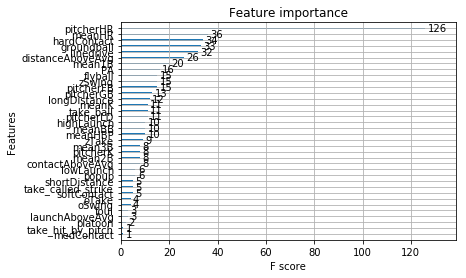

In [11]:
%matplotlib inline
xgb.plot_importance(model)

In [12]:
valid[output] = preds
valid = valid[['batter', output, outcome]]
valid.drop_duplicates(['batter', output], inplace = True)

batters = pd.read_csv('batters.csv', index_col = 0)
batters['batter'] = batters['batter'].astype(int)
valid = pd.merge(valid, batters, on = 'batter', how = 'left')

valid.sort_values([output], ascending = False).head()

,batter,HR,outcomeHR,batter_name
237,571431,0.076231,0,matt adams
326,430832,0.070939,0,jose bautista
91,621566,0.069665,0,matt olson
275,545341,0.068917,0,randal grichuk
78,501981,0.067990,0,khris davis


In [13]:
roc_auc_score(y_true = valid[outcome], y_score = valid[output])

0.5511363636363636

In [16]:
valid['seasonHR'] = valid['HR'] * 700

valid.sort_values([output], ascending = False).head()

,batter,HR,outcomeHR,batter_name,seasonHR
237,571431,0.076231,0,matt adams,53.361549
326,430832,0.070939,0,jose bautista,49.657429
91,621566,0.069665,0,matt olson,48.765156
275,545341,0.068917,0,randal grichuk,48.242050
78,501981,0.067990,0,khris davis,47.593117


In [ ]:
# allPreds = allPreds[allPreds['batter'].isin(startersBat['batter'])]

# allPreds['points'] = allPreds['1B'] * 3 + allPreds['2B'] * 5 + allPreds['3B'] * 8 + allPreds['HR'] * 10 * 5

# allPreds.sort_values(['points'], ascending = False)

In [ ]:
# allPreds.to_csv('allPreds' + outcome + date + '.csv')